### 1 : Importing Libraries

In [1]:
# ignore the warnings in the output
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import libraries and packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import mlflow
from pycaret.classification import *

 ### 2 Reading Data

In [3]:
##Copy the cleaned data obtained from the data_cleaning notebook into the Data folder before proceeding
%time
dataset = pd.read_csv('Data/cleaned_data.csv')

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs


In [4]:
dataset.head()

,created_date,city_tier,first_platform_c,first_utm_medium_c,first_utm_source_c,total_leads_droppped,referred_lead,app_complete_flag,assistance_interaction,career_interaction,payment_interaction,social_interaction,syllabus_interaction
0,2021-07-01 00:08:15,1.0,Level0,Level11,Level2,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
1,2021-07-01 00:16:43,2.0,Level3,Level0,others,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
2,2021-07-01 00:22:20,1.0,Level3,Level0,Level0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
3,2021-07-01 00:23:13,1.0,Level1,Level3,others,2.0,0.0,0,0.0,0.0,0.0,0.0,0.0
4,2021-07-01 00:28:38,1.0,Level3,Level0,Level0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0


In [5]:
# drop the data column as it is not needed for training
dataset = dataset.drop(['created_date'], axis=1)

In [6]:
import utils 
data_for_model, data_unseen = utils.get_validation_unseen_set(dataset, validation_frac=0.05, sample=False, sample_frac=0.1)


### 3 Setting up Environment: 

In [7]:
root_folder = "/home/"

data_directory = root_folder+"data/raw/"
data_profile_path = root_folder+"/data/profile_report/"
intermediate_data_path = root_folder+"data/interim/"
final_processed_data_path = root_folder+"data/processed/"
database_path = root_folder+"database/"

In [23]:
import utils
# create a connection and setup a SQLite database with the name "lead_scoring_model_experimentation.db" in 
# 'Assignment/02_training_pipeline/notebooks/' location
utils.create_sqlit_connection(database_path,r"lead_scoring_model_experimentation.db")

2.6.0


In [9]:
'''
Now you need to start the MLflow server in a new terminal. 
Note: Before you start the MLflow server, create a folder named mlruns in the assignment directory.
Now you need to run the command to start MLflow server such that:
1. The lead_scoring_model_experimentation.db which you created above is used as the backend-store.
2. mlruns folder is used as an artifact directory. 
3. The server runs on the port 6006.

The steps to do so are as follows:
Open a new terminal.
Then go to the Assignment directory using the cd command. Type the command: cd Assignment/
Create a folder named mlruns here. You can create this folder using either the command line or GUI. To create this folder via the command line run the command: mkdir ./mlruns
Then, type the following command to start the MLflow server: 
mlflow server --backend-store-uri='sqlite:///./02_training_pipeline/notebooks/lead_scoring_model_experimentation.db' --default-artifact-root="./mlruns" --port=6006 --host=0.0.0.0
'''
# mlflow server --backend-store-uri='sqlite:///lead_scoring_model_experimentation.db' --default-artifact-root="./mlruns" --port=6006 --host=0.0.0.0

'\nNow you need to start the MLflow server in a new terminal. \nNote: Before you start the MLflow server, create a folder named mlruns in the assignment directory.\nNow you need to run the command to start MLflow server such that:\n1. The lead_scoring_model_experimentation.db which you created above is used as the backend-store.\n2. mlruns folder is used as an artifact directory. \n3. The server runs on the port 6006.\n\nThe steps to do so are as follows:\nOpen a new terminal.\nThen go to the Assignment directory using the cd command. Type the command: cd Assignment/\nCreate a folder named mlruns here. You can create this folder using either the command line or GUI. To create this folder via the command line run the command: mkdir ./mlruns\nThen, type the following command to start the MLflow server: \nmlflow server --backend-store-uri=\'sqlite:///./02_training_pipeline/notebooks/lead_scoring_model_experimentation.db\' --default-artifact-root="./mlruns" --port=6006 --host=0.0.0.0\n'

In [22]:
# Once, your server is successfully running, create a mlflow tracking uri at "http://0.0.0.0:6006"
mlflow.set_tracking_uri("http://0.0.0.0:6006")

In [11]:
# setup pycaret 
from pycaret.classification import *
exp_clf102 = setup(data=data_for_model, target = 'app_complete_flag',  fold_shuffle=True, 
                   session_id = 42,
                   normalize = False, 
                   transformation = False, 
                   ignore_low_variance = True,
                   remove_multicollinearity = True, multicollinearity_threshold = 0.95,
                   #date_features=['registration_init_time','transaction_date_min','transaction_date_max','membership_expire_date_max','last_login'],
                   fix_imbalance=False ,#ignore_features=['msno'],
                   n_jobs=-1,use_gpu=False,
                   log_experiment=True,experiment_name='lead_scoring_model_experimentation',
                   log_plots=True, log_data=True,
                   silent=True, verbose=True,
                   log_profile=False)

,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(227016, 12)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


### 4 : Model Experimentation with pycaret

In [12]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']
best_model = compare_models(fold = 5,exclude=['gbc','knn','qda', 'dummy', 'svm', 'ada'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7363,0.8142,0.8328,0.6999,0.7606,0.4719,0.4808,2.0940
xgboost,Extreme Gradient Boosting,0.7361,0.8139,0.8335,0.6995,0.7606,0.4715,0.4806,14.2160
rf,Random Forest Classifier,0.7350,0.8117,0.8227,0.7018,0.7575,0.4694,0.4766,2.7120
et,Extra Trees Classifier,0.7343,0.8109,0.8202,0.7018,0.7564,0.4680,0.4749,3.3080
dt,Decision Tree Classifier,0.7341,0.8104,0.8200,0.7017,0.7563,0.4677,0.4745,0.1780
lr,Logistic Regression,0.7093,0.7770,0.8195,0.6734,0.7393,0.4178,0.4281,1.2180
ridge,Ridge Classifier,0.6993,0.0000,0.7955,0.6692,0.7269,0.3979,0.4053,0.0780
lda,Linear Discriminant Analysis,0.6993,0.7637,0.7955,0.6692,0.7269,0.3980,0.4054,0.3000
nb,Naive Bayes,0.6600,0.7229,0.8742,0.6138,0.7212,0.3181,0.3520,0.4940


In [13]:
# create a model which gives the highest accuracy
lgbm  = create_model('lightgbm', fold = 5) 

In [25]:
mlflow.sklearn.log_model(sk_model=lgbm,artifact_path="models", registered_model_name='LightGBM1')

Successfully registered model 'LightGBM1'.
2023/04/19 15:47:41 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: LightGBM1, version 1
Created version '1' of model 'LightGBM1'.


ModelInfo(artifact_path='models', flavors={'python_function': {'model_path': 'model.pkl', 'loader_module': 'mlflow.sklearn', 'python_version': '3.8.12', 'env': 'conda.yaml'}, 'sklearn': {'pickled_model': 'model.pkl', 'sklearn_version': '0.23.2', 'serialization_format': 'cloudpickle', 'code': None}}, model_uri='runs:/a354feb3ce854da6b32eadcc5b743360/models', model_uuid='e749333fe9e94498ae02f337ba2a3840', run_id='a354feb3ce854da6b32eadcc5b743360', saved_input_example_info=None, signature_dict=None, utc_time_created='2023-04-19 15:47:38.029335', mlflow_version='1.26.1')

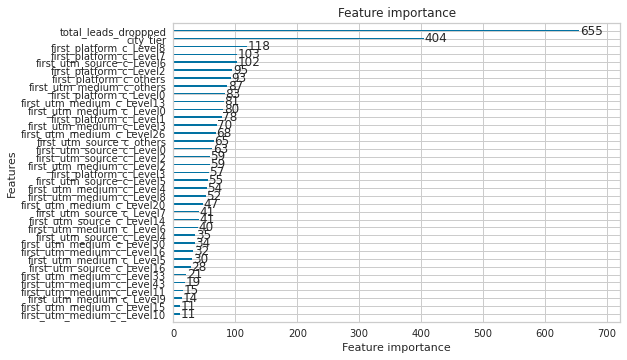

In [14]:
# create feature importance plot
import lightgbm as lgb
import matplotlib.pyplot as plt
lgb.plot_importance(lgbm)
plt.show()

### 5 : Model Experimentation after dropping features

From the above feature tests we can claerly see that some of the features are not significant. We will now drop all the insignificant features and select only the significant ones.
The list of the significant features is 
['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c'].
So now you will train your model with onlly these features.

Also note that in our previous experiments we saw that tree based models are our top performers. In case of tree based models we do not require transformationss normalization, scaling etc. So make sure that you use setup pycaret in the proper way. i.e, make sure that you use normalize = False and transformation = False.

In [15]:
# 
# ['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']
#
# Train the model using the features listed above. Since we are using tree models we do not require any transformaions 
# such as normalization, scaling etc.So make sure that you use setup pycaret in the proper way. i.e, make sure that you use 
# normalize = False and transformation = False.
# setup pycaret 
from pycaret.classification import *
exp_clf102 = setup(data=data_for_model, target = 'app_complete_flag',  fold_shuffle=True, 
                   session_id = 42,
                   normalize = False, 
                   transformation = False, 
                   ignore_low_variance = True,
                   remove_multicollinearity = True, multicollinearity_threshold = 0.95,
                   #date_features=['registration_init_time','transaction_date_min','transaction_date_max','membership_expire_date_max','last_login'],
                   fix_imbalance=False ,
                   ignore_features=['assistance_interaction', 'career_interaction', 'payment_interaction', 'social_interaction', 'syllabus_interaction'],
                   n_jobs=-1,use_gpu=False,
                   log_experiment=True,experiment_name='lead_scoring_model_experimentation_significant',
                   log_plots=True, log_data=True,
                   silent=True, verbose=True,
                   log_profile=False)

,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(227016, 12)"
5,Missing Values,False
6,Numeric Features,2
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


In [16]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']. 
best_model_significant = compare_models(fold = 5,exclude=['gbc','knn','qda', 'dummy', 'svm', 'ada'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7363,0.8142,0.8328,0.6999,0.7606,0.4719,0.4808,2.4240
xgboost,Extreme Gradient Boosting,0.7361,0.8139,0.8335,0.6995,0.7606,0.4715,0.4806,24.9360
rf,Random Forest Classifier,0.7350,0.8117,0.8227,0.7018,0.7575,0.4694,0.4766,5.7300
et,Extra Trees Classifier,0.7343,0.8109,0.8202,0.7018,0.7564,0.4680,0.4749,8.2460
dt,Decision Tree Classifier,0.7341,0.8104,0.8200,0.7017,0.7563,0.4677,0.4745,0.2180
lr,Logistic Regression,0.7093,0.7770,0.8195,0.6734,0.7393,0.4178,0.4281,1.6140
ridge,Ridge Classifier,0.6993,0.0000,0.7955,0.6692,0.7269,0.3979,0.4053,0.0840
lda,Linear Discriminant Analysis,0.6993,0.7637,0.7955,0.6692,0.7269,0.3980,0.4054,0.5840
nb,Naive Bayes,0.6600,0.7229,0.8742,0.6138,0.7212,0.3181,0.3520,0.1740


In [17]:
# You should get lightgbm as the best performing model. So now we will train a lightGBM model manually using pycaret
lgbm  = create_model('lightgbm', fold = 10) 

In [18]:
!pip install optuna

  Using cached optuna-3.1.1-py3-none-any.whl (365 kB)
  Using cached cmaes-0.9.1-py3-none-any.whl (21 kB)


In [19]:
from optuna.distributions import IntDistribution

# Define the search space for the hyperparameters
param_distributions = {
    'num_leaves': IntDistribution(low=10, high=100)
}

In [20]:
# Tune the hyper parameters of the lightgbm model using optuna on 10 folds and optimise AUC as that was our system metric, 
# hence we will optimise AUC
tuned_lgbm, tuner_0 = tune_model(lgbm, 
                            fold = 10,                                    
                            search_library='optuna',
                            search_algorithm='random',
                            optimize = 'AUC',
                            custom_grid = param_distributions,
                            choose_better = True, 
                            return_tuner=True)

In [21]:
# Print the final models configuration so that we can use it in the model retraining pipeline 
print(tuned_lgbm)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


/opt/conda/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/conda/lib